In [1]:
import pandas as pd
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../dataset/clean_dataset++.xlsx')
data = data.sample(frac = 1, random_state=7).reset_index(drop=True)
data

,id,Label_1,Label_2,Original,Quantity,Price,MUNICIPIO,DATA,Text
0,5398,742,414,COMBODART 0 5MG+0 4MG 30CAP GEL DURA,2,118.66,GUARABIRA,2020-03-27 00:00:00.000,COMBODART 5 4 30
1,318,37,11,ACETILCISTEINA AD XPE 120ML,1,23.33,PATOS,2020-06-18 00:00:00.000,ACETILCISTEINA AD 120
2,5069,686,378,CLORIDRATO DE HIDROXIZINA 25 MG C/ 30 CPR,2,14.99,PATOS,2020-06-10 00:00:00.000,CLORIDRATO HIDROXIZINA 25 30
3,14796,2274,1136,OPTIVE COL 10 ML*,1,51.74,ALHANDRA,2020-03-16 00:00:00.000,OPTIVE COL 10
4,16049,2470,1222,PRESSALIV 5ML,1,74.15,GUARABIRA,2020-03-10 00:00:00.000,PRESSALIV 5
...,...,...,...,...,...,...,...,...,...
21111,919,129,64,ALENIA 12/400MCG C/60CAPS+INALADOR,1,145.82,PATOS,2020-03-09 00:00:00.000,ALENIA 12 400 60
21112,20691,3172,1522,VICOG 5MG C/30 COMP,1,25.11,POMBAL,2020-05-06 00:00:00.000,VICOG 5 30
21113,5699,788,442,CYSTEX FR 24 DRG,1,20.22,DONA INES,2020-04-07 00:00:00.000,CYSTEX FR 24
21114,10742,1528,753,GEN-NIMESULIDA 100MG C/12 LEGR,1,7.00,ITAPOROROCA,2020-07-28 00:00:00.000,GEN NIMESULIDA 100 12


In [52]:
def clustering(target, df):
    div = 5000
    stuck = 0
    val = 0
    minimum = 0
    maximum = 0
    t0 = time()
    while val != target and div != stuck:
        df['Cluster'] = 0
        df.loc[df['decoded_txt'] > df['decoded_txt'].shift(1)*(1+(1/div)), 'Cluster'] = 1
        val = df['Cluster'].isin([1]).sum()
        stuck = div
        if(val > target):
            maximum = div
            div = (maximum + minimum)//2
        else:
            if(maximum == 0):
                div = div*2
            else:
                minimum = div
                div = (maximum + minimum)//2
    df['Cluster'] = df['Cluster'].cumsum()
    print("Clustering finished for %d clusters." % val)
    print("Done in %f seconds." % (time() - t0))
    return df

In [4]:
SEQLEN = 10
EMBEDDING_SIZE = 10

text_input = data['Text']

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='',
    lower=True, split=' ')
    
tokenizer.fit_on_texts(text_input)
vocab_size = len(tokenizer.word_index)

x = tokenizer.texts_to_sequences(text_input)   
data_in = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=SEQLEN,
                                                    padding='post')
data_out = data_in

In [85]:
# Text Input
text_input = tf.keras.layers.Input(shape=(SEQLEN,), name='text_input')
x = tf.keras.layers.Embedding(vocab_size + 1, EMBEDDING_SIZE,
                              input_length=SEQLEN)(text_input)

ae_input = tf.keras.layers.Flatten()(x)

# Encoder                      
encoded = tf.keras.layers.Dense(SEQLEN, activation='relu')(ae_input)
encoded = tf.keras.layers.Dense(8, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(4, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(4, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(8, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(SEQLEN, name='decoded_txt')(decoded)

autoencoder = tf.keras.Model(text_input, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss='mse',
                    metrics=['mse', 'mae'])

autoencoder.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 10)]              0         
_________________________________________________________________
embedding_22 (Embedding)     (None, 10, 10)            24530     
_________________________________________________________________
flatten_22 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_110 (Dense)            (None, 10)                1010      
_________________________________________________________________
dense_111 (Dense)            (None, 8)                 88        
_________________________________________________________________
dense_112 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_113 (Dense)            (None, 4)                 20 

In [86]:
df = data.copy()

t0 = time()
history = autoencoder.fit(data_in, data_out,
                            epochs=1,
                            validation_split=0.2)
                            
predicted = autoencoder.predict(data_in)
print("Autoencoder model finished training in %f seconds." % (time() - t0))

df['decoded_txt'] = predicted.mean(axis=1).tolist()

df = df.sort_values(by=['decoded_txt']).reset_index(drop=True)
df1 = clustering(3273, df.copy())
df2 = clustering(1564, df.copy())

print("Total: %f seconds." % (time() - t0))

528/528 [==============================] - 2s 2ms/step - loss: 40851.1469 - mse: 40851.1469 - mae: 54.8218 - val_loss: 34586.8398 - val_mse: 34586.8398 - val_mae: 52.7186
Autoencoder model finished training in 2.504275 seconds.
Clustering finished for 3273 clusters.
Done in 0.036515 seconds.
Clustering finished for 1563 clusters.
Done in 0.035000 seconds.
Total: 2.590789 seconds.


In [87]:
df1 = df1.sort_values(by=['id']).reset_index(drop=True)
df2 = df2.sort_values(by=['id']).reset_index(drop=True)
df = df.sort_values(by=['id']).reset_index(drop=True)
df['Cluster 1'] = df1['Cluster']
df['Cluster 2'] = df2['Cluster']
df.to_excel("../dataset/autoencoder++.xlsx", index=False)

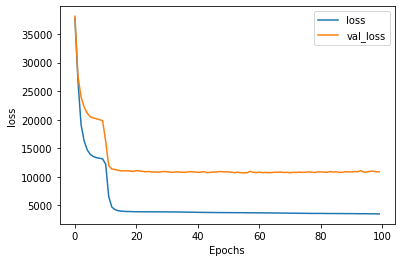

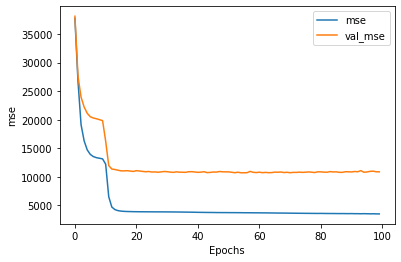

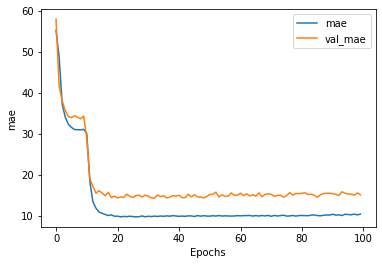

In [74]:
metrics = ['loss', 'mse', 'mae']
for metric in metrics:
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plot_name = '../results/' + metric + '.svg'
    plt.savefig(plot_name)
    plt.show()

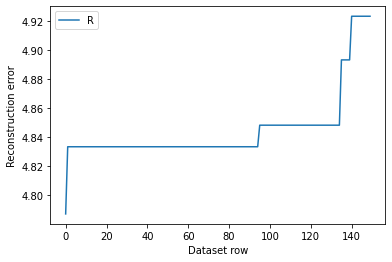

In [83]:
plt.plot(df['decoded_txt'].head(150))
plt.xlabel("Dataset row")
plt.ylabel("Reconstruction error")
plt.legend("Reconstruction error increase per row")
plt.show()